In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

# Define image size and number of classes
IMG_SIZE = 245
NUM_CLASSES = 4  # 4 classes: meningioma, pituitary, glioma, no_tumor

# Load EfficientNetB6 with pre-trained weights and exclude the top layers for fine-tuning
base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model to prevent training its weights
base_model.trainable = False

# Custom Layers
model = Sequential([
    base_model,  # Base EfficientNetB6
    GlobalAveragePooling2D(),  # Global Average Pooling
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for 4 classes
])

# Define Adam optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training, validation, and test data from directories
train_generator = train_datagen.flow_from_directory(
    'path/to/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'path/to/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'path/to/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')

# Predictions on the test set
test_predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
recall = recall_score(test_true_classes, test_pred_classes, average='weighted')
f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')
accuracy = accuracy_score(test_true_classes, test_pred_classes)

# Specificity Calculation
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Specificity'],
    'Value': [precision, recall, f1, accuracy, np.mean(specificity)]
})

print(metrics_df)

# Save the model to an H5 file
model.save('brain_tumor_classifier.h5')
print("Model saved as brain_tumor_classifier.h5")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 1653 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 492s 8s/step - accuracy: 0.7003 - loss: 0.6994
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.8925 - loss: 0.2362
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.9283 - loss: 0.1909
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 159us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.9514 - loss: 0.1310
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.9503 - loss: 0.1251
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


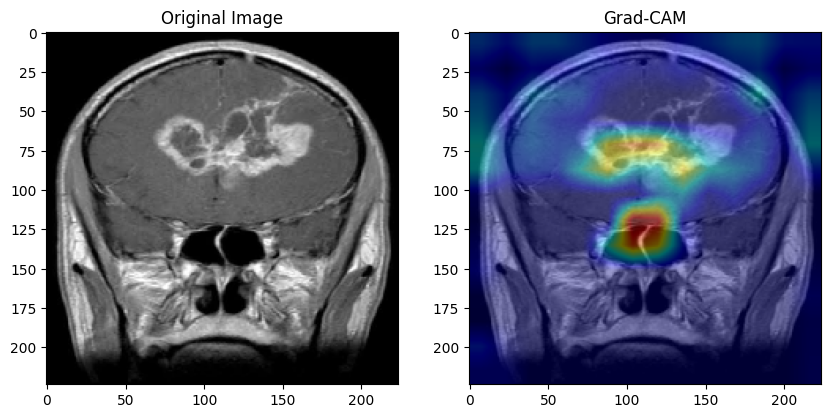

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load trained model
model = load_model('brain_tumor_classifier.h5')

# Choose the last convolutional layer of EfficientNetB6
last_conv_layer_name = 'top_conv'  # Check model summary if needed

def get_gradcam(model, img_array, class_idx, layer_name=last_conv_layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    weighted_sum = np.dot(conv_outputs, guided_grads)

    cam = np.maximum(weighted_sum, 0)
    cam = cam / cam.max() if cam.max() > 0 else cam
    return cam

# Preprocess input image
def preprocess_image(image_path, img_size=245):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, img

# Visualize Grad-CAM overlay
def visualize_gradcam(image_path, cam, original_img):
    cam = cv2.resize(cam, (original_img.width, original_img.height))
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    overlay = (0.4 * cam + np.array(original_img) * 0.6).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.show()

# Load and preprocess test image
test_img_path = 'path/to/test/image.jpg'  # Replace with actual image path
img_array, original_img = preprocess_image(test_img_path)

# Predict class
predictions = model.predict(img_array)
class_idx = np.argmax(predictions[0])

# Get Grad-CAM heatmap
cam = get_gradcam(model, img_array, class_idx)

# Visualize results
visualize_gradcam(test_img_path, cam, original_img)

